#### Cargamos el dataset y normalizamos las columnas

#### Aplicación de K-MEANS al CRISIS
* En 

#### Conclusiones
* 
* 

#### Cargamos librerías

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


#### Cargamos la matriz de aspectos y la descripción de las variables 'per'

In [44]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['CRISIS_FINANCIERA_2008'],
    'var_1': ['per401'],
    'var_2': ['per403'],
    'var_3': ['per503'],  # None indica que no hay una tercera variable para el aspecto
    'var_4': ['per504']  
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4
0,CRISIS_FINANCIERA_2008,per401,per403,per503,per504


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


#### 1.Filtrar y Normalizar datos

In [45]:
# Cargar el dataset principal
file_path = './data/MP_Dataset_KMeans.xlsx'
df = pd.read_excel(file_path)

# Filtrar el DataFrame según las variables del aspecto seleccionado y el período
aspecto_filtro = 'CRISIS_FINANCIERA_2008'
desde = 2008
hasta = 2010

variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4']].dropna().values.flatten()

# Filtrar el DataFrame para las variables del aspecto, y normalizar si es necesario
df_filtered = df[(df['agno'] >= desde) & (df['agno'] <= hasta)][['countryname', 'agno'] + list(variables)].copy()
df_filtered.dropna(inplace=True)

# Normalizar las columnas per
columns_per = variables
df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
rows_to_normalize = df_filtered['per_sum'] != 1.0
df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
    df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
)
df_filtered.drop(columns=['per_sum'], inplace=True)

# Verificar que las variables per sumen 1
assert df_filtered[columns_per].sum(axis=1).round(6).eq(1).all(), "Error: las variables per no suman 1."


In [46]:
# print(df_filtered.info())
# print(df_filtered.head(10))


#### 2.Realizar PCA

In [47]:
# Seleccionar sólo las columnas numéricas (per) para PCA
numeric_data = df_filtered[columns_per]

# Ejecutar PCA
pca = PCA(n_components=3)
pca_components = pca.fit_transform(numeric_data)

# Crear un DataFrame con las componentes principales
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])

# Combinar con las columnas categóricas
df_pca = pd.concat([df_filtered[['countryname', 'agno']].reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# Verificar el resultado
# print(df_pca.info())
# print(df_pca.head(10))


#### Varianza explicada por cada componente de PCA

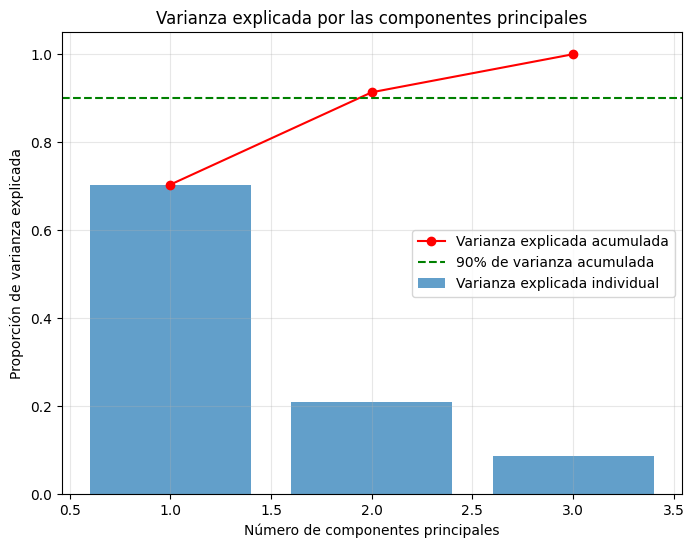

Componente 1: 0.7038 (0.7038 acumulado)
Componente 2: 0.2097 (0.9135 acumulado)
Componente 3: 0.0865 (1.0000 acumulado)


In [48]:
# Varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

# Varianza acumulada
explained_variance_cumulative = np.cumsum(explained_variance_ratio)

# Visualización de la varianza explicada
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Varianza explicada individual')
plt.plot(range(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, marker='o', color='red', label='Varianza explicada acumulada')
plt.title('Varianza explicada por las componentes principales')
plt.xlabel('Número de componentes principales')
plt.ylabel('Proporción de varianza explicada')
plt.axhline(y=0.9, color='green', linestyle='--', label='90% de varianza acumulada')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Imprimir la varianza explicada
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Componente {i}: {ratio:.4f} ({explained_variance_cumulative[i-1]:.4f} acumulado)")


In [49]:
# Calcular las cargas de las variables originales en las componentes principales
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=columns_per
)
# Mostrar las cargas
display(loadings)


,PC1,PC2,PC3
per401,0.118049,-0.047614,0.856620
per403,0.119244,0.816497,-0.262894
per503,0.568264,-0.517623,-0.398928
per504,-0.805557,-0.251261,-0.194798


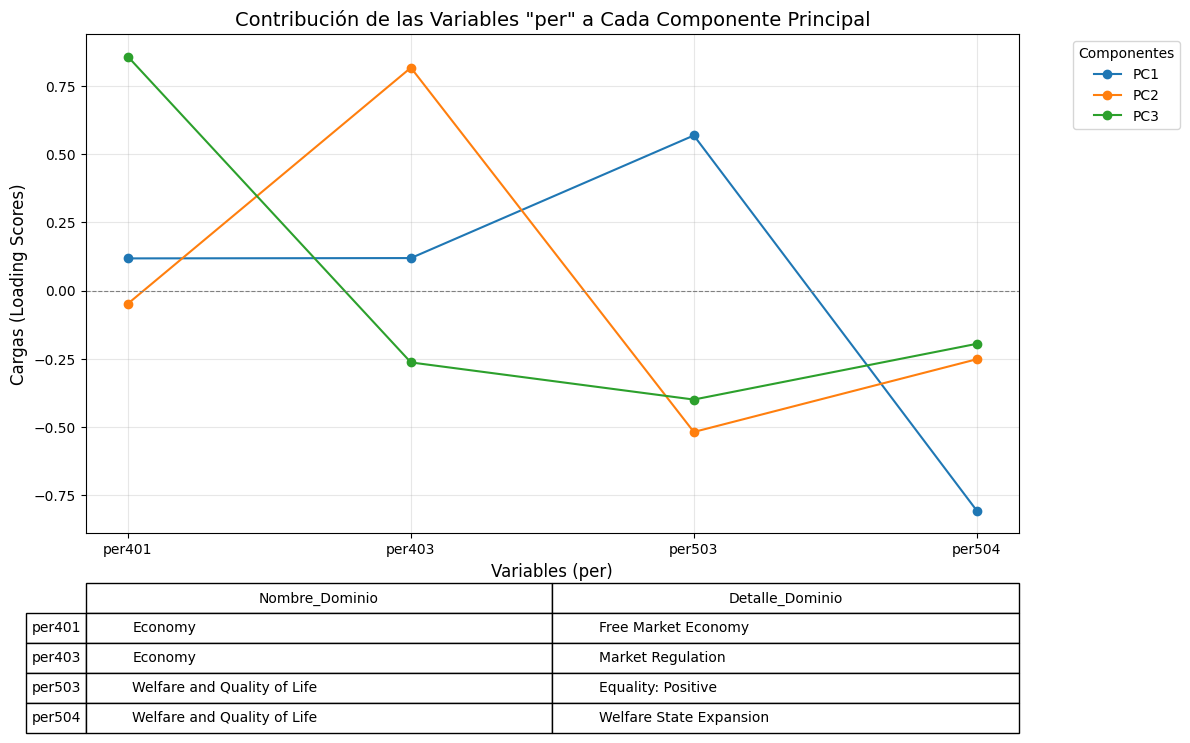

In [50]:
# Calcular las cargas (loading scores)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=columns_per
)

# Obtener información de las variables del aspecto desde df_AD
variables_info = df_AD[df_AD['Variable_per'].isin(columns_per)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]
variables_info = variables_info.set_index('Variable_per').reindex(columns_per)

# Graficar las cargas para cada componente principal
fig, ax = plt.subplots(figsize=(12, 8))

for i, col in enumerate(loadings.columns):
    ax.plot(loadings.index, loadings[col], marker='o', label=col)

# Configuración del gráfico
ax.set_title('Contribución de las Variables "per" a Cada Componente Principal', fontsize=14)
ax.set_xlabel('Variables (per)', fontsize=12)
ax.set_ylabel('Cargas (Loading Scores)', fontsize=12)
ax.set_xticks(range(len(loadings.index)))
ax.set_xticklabels(loadings.index, rotation=0, ha='center')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.legend(title='Componentes', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

# Crear la tabla con la información adicional
from matplotlib.table import Table

table_data = variables_info[['Nombre_Dominio', 'Detalle_Dominio']].values
table_col_labels = ['Nombre_Dominio', 'Detalle_Dominio']
table_row_labels = variables_info.index

# Agregar la tabla al gráfico
table = plt.table(cellText=table_data,
                  colLabels=table_col_labels,
                  rowLabels=table_row_labels,
                  cellLoc='left',
                  loc='bottom',
                  bbox=[0.0, -0.4, 1.0, 0.3])  # Ajustar posición y tamaño

# Ajustar diseño
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.2)

plt.tight_layout()
plt.show()


#### 3.Elbow + K-MEANS
* Con K-MEANS vemos si es que los componentes principales forman clusteres
* Para saber el número óptimo de clusteres en un método de clasificación como K_MEANS, usamos el "elbow method". Este método:
* * Calcula los WCSS (Within-Cluster Sum of Squares): Mide la suma de las distancias cuadradas entre los puntos de datos y el centroide de su clúster.
* * Se calcula WCSS para diferentes números de clústeres (kk)
* * Al graficar kk contra WCSS, la curva normalmente muestra una pendiente pronunciada que luego se estabiliza.
* * El "codo" es el punto donde la reducción en WCSS deja de ser significativa, indicando que agregar más clústeres no mejora sustancialmente la compactación

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

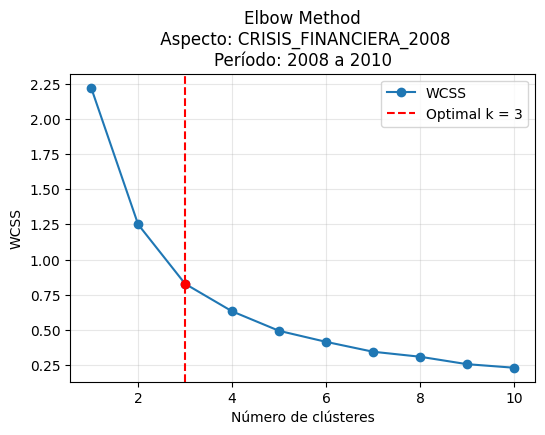

El número óptimo de clústeres (elbow method) es: 3


In [51]:
from kneed import KneeLocator

# Usar los datos normalizados de 'numeric_data' para calcular WCSS
data_scaled = numeric_data  # Asegúrate de que sea el conjunto de datos numéricos normalizados

# Calcular WCSS para determinar el número óptimo de clústeres
max_k = 10
wcss = []
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Encontrar el codo automáticamente
kl = KneeLocator(range(1, max_k + 1), wcss, curve="convex", direction="decreasing")
optimal_k = kl.knee

# Graficar el método del codo
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_k + 1), wcss, marker='o', label="WCSS")
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.scatter(optimal_k, wcss[optimal_k - 1], color='red', zorder=5)  # Punto del codo
plt.title(f"Elbow Method\n Aspecto: {aspecto_filtro}\nPeríodo: {desde} a {hasta}")
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"El número óptimo de clústeres (elbow method) es: {optimal_k}")


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


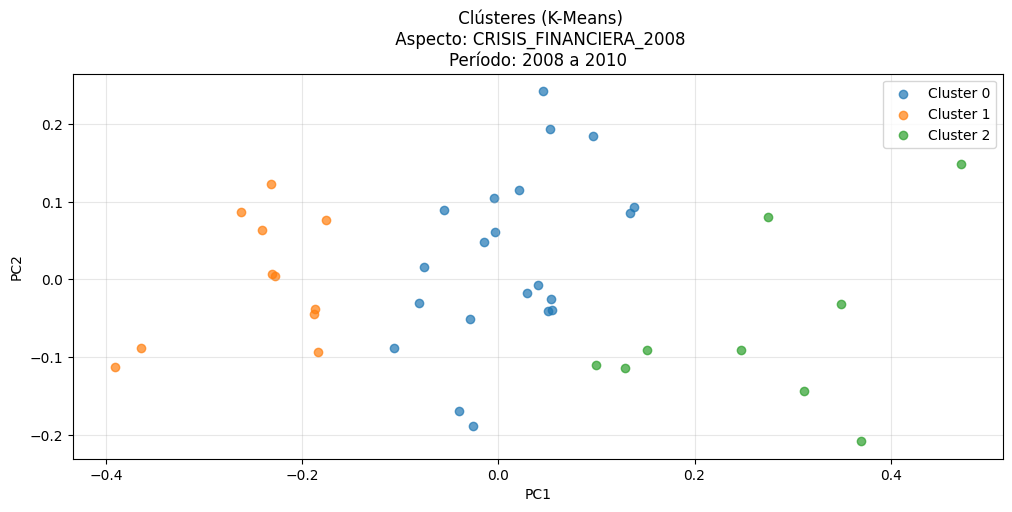

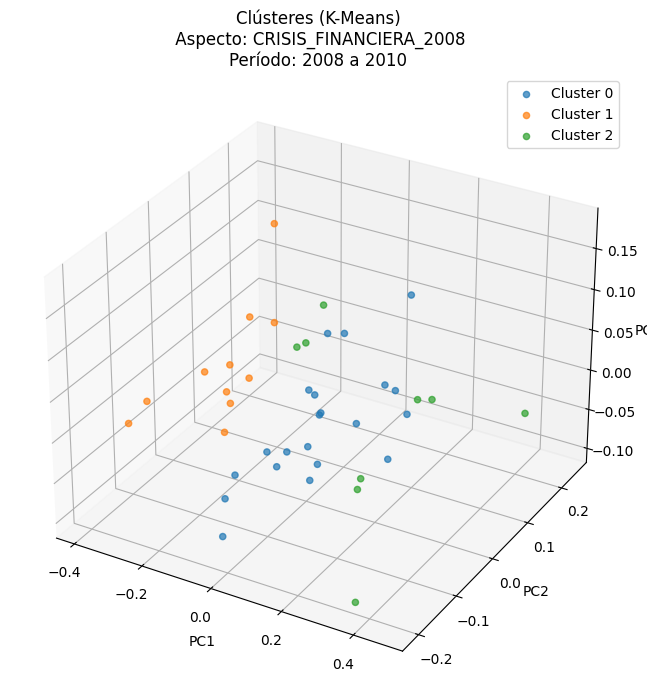

In [52]:
from mpl_toolkits.mplot3d import Axes3D
# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(df_pca[['PC1', 'PC2', 'PC3']])

# Visualizar clústeres en 2D
plt.figure(figsize=(12, 5))
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title(f" Clústeres (K-Means)\n Aspecto: {aspecto_filtro}\nPeríodo: {desde} a {hasta}")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Visualizar clústeres en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', alpha=0.7)

ax.set_title(f"Clústeres (K-Means)\n Aspecto: {aspecto_filtro}\nPeríodo: {desde} a {hasta}")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()


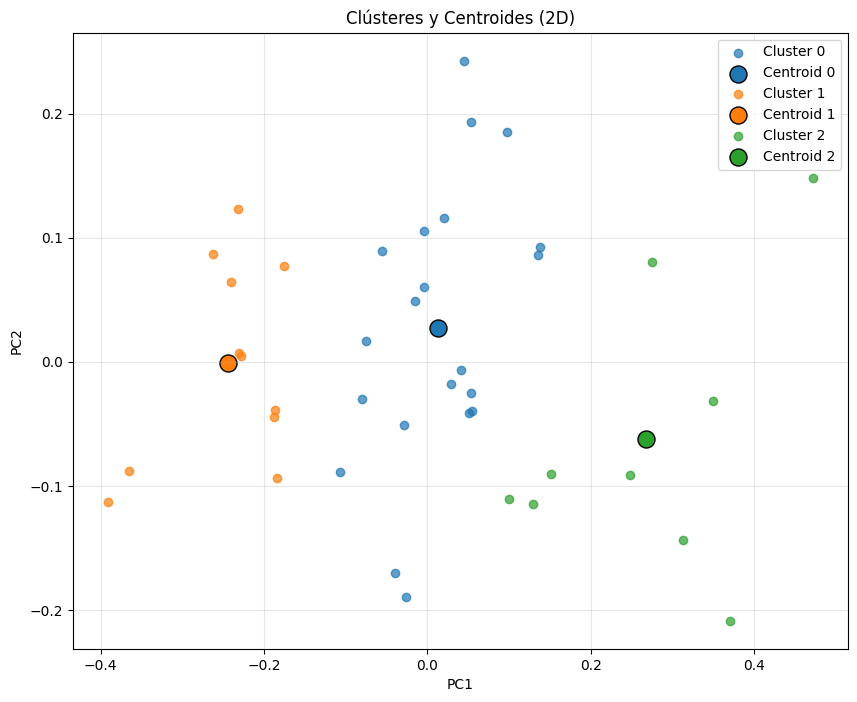

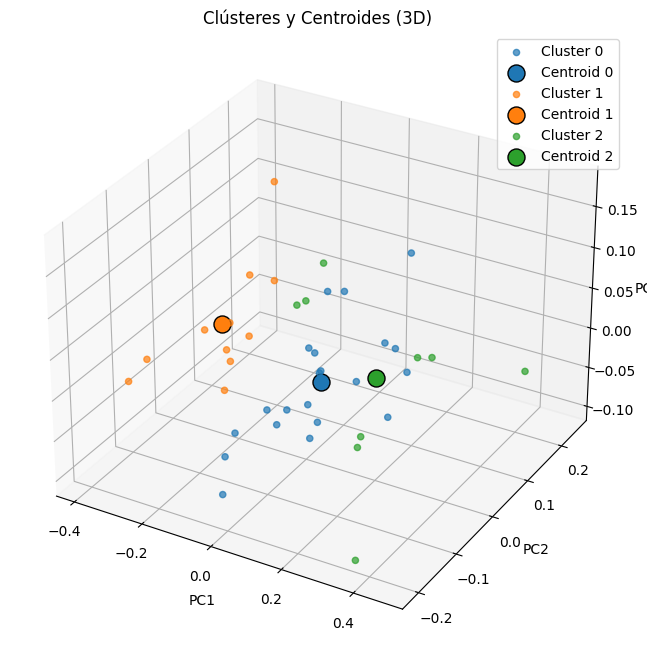

Coordenadas de los centroides:


,PC1,PC2,PC3
0,0.013385,0.027425,-0.030640
1,-0.244134,-0.001338,0.021597
2,0.267153,-0.062356,0.045098


In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener los centroides del modelo K-Means
centroids = kmeans.cluster_centers_

# Crear un DataFrame para los centroides con las etiquetas de los componentes principales
centroids_df = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])

# Crear una paleta de colores para los clústeres
colors = plt.cm.tab10(range(optimal_k))

# Gráfico en 2D
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7, color=colors[cluster])
    
    # Añadir los centroides con el color correspondiente
    plt.scatter(centroids[cluster, 0], centroids[cluster, 1], color=colors[cluster], edgecolor='black', s=150, label=f'Centroid {cluster}')

plt.title('Clústeres y Centroides (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Gráfico en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', alpha=0.7, color=colors[cluster])

    # Añadir los centroides con el color correspondiente
    ax.scatter(centroids[cluster, 0], centroids[cluster, 1], centroids[cluster, 2], color=colors[cluster], edgecolor='black', s=150, label=f'Centroid {cluster}')

ax.set_title('Clústeres y Centroides (3D)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()

# Mostrar las coordenadas de los centroides
print("Coordenadas de los centroides:")
display(centroids_df)


#### ANÁLISIS hasta aquí

### **1. Interpretación de las componentes principales (PCA):**
El **PCA** reduce las variables originales (`per401`, `per403`, `per503`, `per504` , etc.) a unas pocas **componentes principales** (`PC1`, `PC2`, `PC3`). Estas componentes son combinaciones lineales de las variables originales que explican la mayor parte de la varianza en los datos.

#### ¿Cómo interpretar las componentes principales?
- **Ejes de información:** 
  Cada componente principal representa una dimensión en la que los programas de gobierno tienen características similares o diferentes.
  
- **Contribución de las variables originales:**
  Usamos el gráfico de contribuciones (que ya generamos) para identificar qué variables (`per`) están contribuyendo más a cada componente:
  - Si `per401` contribuye mucho a `PC1`, entonces `PC1` captura diferencias entre programas en términos de esa variable.
  - Si `per403` contribuye mucho a `PC2`, entonces `PC2` captura diferencias relacionadas con esa otra variable.

#### Ejemplo de interpretación:
- **PC1**: Si `PC1` tiene una alta contribución de variables relacionadas con el gasto público (como `per401`), podríamos interpretar que los programas se diferencian en cómo abordan políticas de gasto.
- **PC2**: Si `PC2` está dominada por variables relacionadas con impuestos (como `per403`), esta dimensión podría estar asociada a enfoques sobre tributación.

---

### **2. Interpretación de los clústeres (K-Means):**
El **K-Means** agrupa programas de gobierno similares en función de las componentes principales (`PC1`, `PC2`, `PC3`).

#### ¿Qué significa estar en un mismo clúster?
- **Similitud:** Los programas dentro de un clúster tienen patrones comunes en las variables `per` del aspecto analizado.
  - Por ejemplo, un clúster podría agrupar programas que enfatizan políticas expansivas durante la crisis financiera.
- **Diferencias:** Los clústeres representan grupos que son distintos entre sí.
  - Si un clúster agrupa programas que enfatizan gasto público, otro podría enfocarse más en políticas de austeridad.

#### Cómo interpretar los gráficos:
- **2D o 3D:** Los puntos que están cerca en el gráfico representan programas más similares según las componentes principales.
- **Separación entre clústeres:** Si los clústeres están bien definidos (poca superposición), los programas de cada clúster tienen diferencias claras.

---

### **3. Pasos para interpretar los resultados:**

#### a) Explorar los países y períodos en cada clúster:
- ¿Qué países están en cada clúster?
- ¿Hay patrones regionales o temporales (por ejemplo, países europeos en un clúster y países latinoamericanos en otro)?

#### b) Revisar los centroides de los clústeres:
- Los centroides indican los "valores promedio" de las componentes principales para cada clúster.
- Comparar los centroides ayuda a entender cómo los clústeres son diferentes entre sí.

#### c) Relacionar clústeres con las variables originales:
- Usar las contribuciones de las variables a las componentes principales para interpretar las características de cada clúster.
  - Por ejemplo, si `PC1` captura gasto público y un clúster tiene un centroid alto en `PC1`, los programas en ese clúster probablemente priorizan el gasto público.

---

### **4. Ejemplo práctico:**
Supongamos que:
- **PC1** representa "políticas de gasto público".
- **PC2** representa "enfoques tributarios".
- Los gráficos de clústeres muestran que:
  - **Clúster 0** agrupa países europeos durante 2008-2010 con énfasis en austeridad.
  - **Clúster 1** incluye países latinoamericanos que adoptaron políticas expansivas.
  - **Clúster 2** contiene países asiáticos con un enfoque mixto.

Esto podría indicar que los programas de gobierno respondieron a la crisis financiera de manera distinta según el contexto regional.

---

### **¿Qué puedes hacer ahora?**
1. Analiza los países y períodos en cada clúster.
   - ¿Hay patrones regionales o temporales?
   - ¿Qué variables dominan los programas en cada clúster?
2. Relaciona los clústeres con eventos históricos.
   - Por ejemplo, ¿los programas en un clúster reflejan políticas recomendadas por organismos internacionales durante la crisis financiera?

¿Te gustaría que preparemos más celdas para facilitar este análisis? 😊

#### 4.Visualizar clusters

In [36]:
# Explorar los países y períodos en cada clúster
for cluster in range(optimal_k):
    cluster_data = df_pca[df_pca['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Total Programas: {len(cluster_data)}")
    print("Países y años:")
    display(cluster_data)
    # for country, group in cluster_data.groupby('countryname'):
    #     years = group['agno'].tolist()
    #     print(f"- {country}: {len(years)} programas ({', '.join(map(str, years))})")



Cluster 0:
Total Programas: 21
Países y años:


,countryname,agno,PC1,PC2,PC3,cluster
2,Belgium,2010,0.134717,0.085950,0.009486,0
5,Brazil,2010,-0.106490,-0.089008,-0.059995,0
6,Bulgaria,2009,-0.003910,0.060439,0.066660,0
7,Canada,2008,0.096732,0.185065,-0.073782,0
8,Chile,2009,0.138138,0.092694,-0.086835,0
9,Colombia,2010,-0.028705,-0.050659,-0.055949,0
10,Costa Rica,2010,0.040457,-0.006687,-0.062939,0
11,Czech Republic,2010,-0.004404,0.105461,0.048790,0
15,Hungary,2010,0.020778,0.115535,-0.066052,0
19,Latvia,2010,-0.075435,0.016581,-0.072434,0



Cluster 1:
Total Programas: 11
Países y años:


,countryname,agno,PC1,PC2,PC3,cluster
0,Australia,2010,-0.390829,-0.112604,-0.021970,1
3,Bolivia,2009,-0.188007,-0.044833,-0.035848,1
4,Bosnia-Herzegovina,2010,-0.364913,-0.087820,-0.001452,1
17,Italy,2008,-0.175931,0.076907,0.174096,1
18,Japan,2009,-0.231262,0.007328,-0.026834,1
22,Moldova,2009,-0.262971,0.086674,0.045849,1
23,Moldova,2010,-0.231809,0.123447,0.028029,1
24,Montenegro,2009,-0.187074,-0.038760,0.012319,1
27,North Macedonia,2008,-0.227777,0.004728,0.023032,1
28,Norway,2009,-0.184056,-0.093858,0.059853,1



Cluster 2:
Total Programas: 9
Países y años:


,countryname,agno,PC1,PC2,PC3,cluster
1,Austria,2008,0.369782,-0.208598,-0.098168,2
12,Ecuador,2009,0.247706,-0.091529,-0.029696,2
13,Georgia,2008,0.099211,-0.110293,0.130847,2
14,Germany,2009,0.471404,0.148194,-0.009506,2
16,Iceland,2009,0.312174,-0.143225,0.014820,2
25,Netherlands,2010,0.349045,-0.031609,0.066986,2
26,New Zealand,2008,0.151231,-0.090394,0.178405,2
34,Slovenia,2008,0.128676,-0.114299,0.141016,2
40,United States,2008,0.275151,0.080553,0.011180,2


#### 5. Análisis de clusters